In [1]:
import numpy as np
import torch
import cv2
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from pandas.core.common import flatten
from torchvision import datasets, transforms, models
import copy
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

In [2]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
train_data_path = '/home/legendarygene/Desktop/All Data/Small Dataset/Train' 
test_data_path = '/home/legendarygene/Desktop/All Data/Handwritten Dataset/Train'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /home/legendarygene/Desktop/All Data/Small Dataset/Train/6/6_110.jpg
class example:  div
Train size: 6200
Valid size: 1551
Test size: 649


In [4]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [9]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [7]:
train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [11]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

TypeError: RGBShift transformation expects 3-channel images.

In [3]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform_train = transforms.Compose([transforms.Resize((64,64)),
									  transforms.Grayscale(),
									  transforms.RandomRotation(10),
									  transforms.ToTensor(),
    								  transforms.Normalize((0.5), (0.5))])
transform_test = transforms.Compose([transforms.Resize((64,64)),
									 transforms.Grayscale(),
									 transforms.ToTensor(),
									 transforms.Normalize((0.5), (0.5))])
train_data = torchvision.datasets.ImageFolder('~/Desktop/All Data/Small Dataset/Train', transform=transform_train)
test_data = torchvision.datasets.ImageFolder('~/Desktop/All Data/Handwritten Dataset/Train', transform=transform_test)
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers=num_workers,shuffle = True)
classes=['+','-','0','1','2','3','4','5','6','7','8','9','div','times']

In [4]:
class Network(nn.Module):
	def __init__(self):
		super(Network,self).__init__()
		self.cl1=nn.Conv2d(1,16,3,padding=1)
		self.cl1_bn=nn.BatchNorm2d(16)
		self.cl2=nn.Conv2d(16,32,3,padding=1)
		self.cl2_bn=nn.BatchNorm2d(32)
		self.cl3=nn.Conv2d(32,64,3,padding=1)
		self.cl3_bn=nn.BatchNorm2d(64)
		self.dropout=nn.Dropout(0.2)
		self.fc1=nn.Linear(4096,1024)
		self.fc1_bn=nn.BatchNorm1d(1024)
		self.fc2=nn.Linear(1024,256)
		self.fc2_bn=nn.BatchNorm1d(256)
		self.fc3=nn.Linear(256,14)
		self.pool=nn.MaxPool2d(2,2)

	def forward(self,x):
		x=self.cl1(x)
		x=self.pool(F.leaky_relu(self.cl1_bn(x)))
		x=self.cl2(x)
		x=self.pool(F.leaky_relu(self.cl2_bn(x)))
		x=self.cl3(x)
		x=self.pool(F.leaky_relu(self.cl3_bn(x)))
		x=x.view(-1,4096)
		self.dropout(x)
		x=self.fc1(x)
		x=F.relu(self.fc1_bn(x))
		self.dropout(x)
		x=self.fc2(x)
		x=F.relu(self.fc2_bn(x))
		self.dropout(x)
		x=self.fc3(x)
		return x

model=Network()
model.cuda()

Network(
  (cl1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cl3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc2_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=14, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [5]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0015)

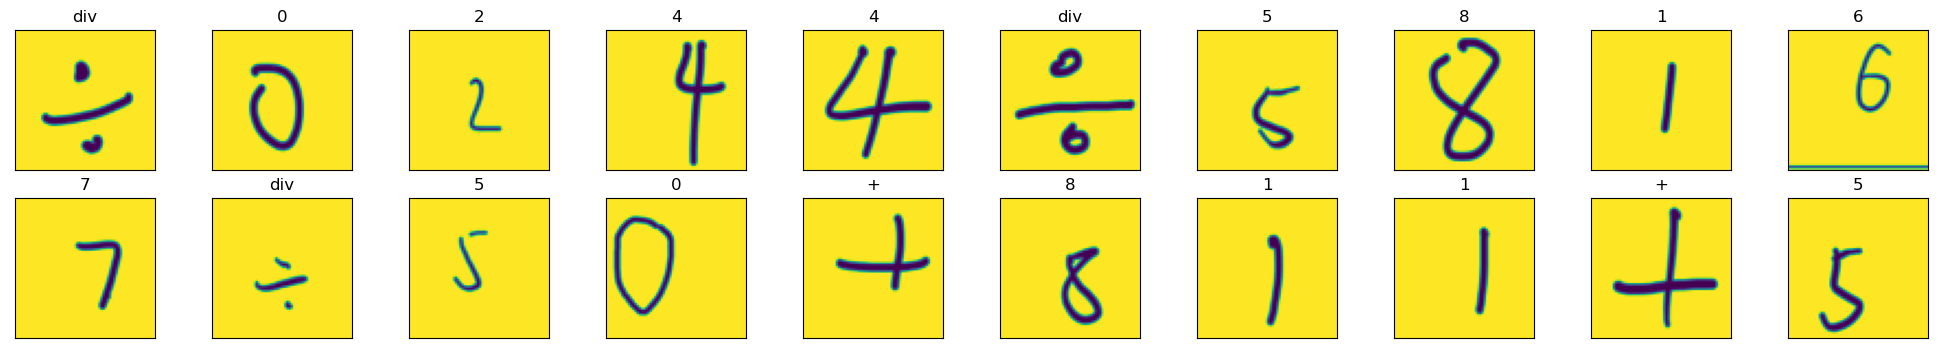

In [6]:
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))  
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
epochs=30
train_losses=np.array([])
valid_losses=np.array([])
ep=np.array([])
valid_loss_min = np.Inf
for e in range(epochs):
	train_loss=0.0
	valid_loss=0.0
	model.train()
	for data, target in train_loader:
		data, target = data.cuda(), target.cuda()
		output=model(data)
		optimizer.zero_grad()
		loss=criterion(output,target)
		loss.backward()
		optimizer.step()
		train_loss+=loss.item()*data.size(0)
	model.eval()
	for data, target in valid_loader:
		data, target = data.cuda(), target.cuda()
		output = model(data)
		loss = criterion(output, target)																
		valid_loss += loss.item()*data.size(0)   
	train_loss = train_loss/len(train_loader.sampler)
	valid_loss = valid_loss/len(valid_loader.sampler)
	train_losses=np.append(train_losses,train_loss)
	valid_losses=np.append(valid_losses,valid_loss)
	ep=np.append(ep,e)
	print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
		e, train_loss, valid_loss))   
	if valid_loss <= valid_loss_min:
		print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
		torch.save(model.state_dict(), 'model_ERA_Small_lr0015.pt')
		valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.154073 	Validation Loss: 0.097408
Validation loss decreased (inf --> 0.097408).  Saving model ...
Epoch: 1 	Training Loss: 0.037667 	Validation Loss: 0.171043
Epoch: 2 	Training Loss: 0.039900 	Validation Loss: 0.194105
Epoch: 3 	Training Loss: 0.039199 	Validation Loss: 0.131432
Epoch: 4 	Training Loss: 0.014623 	Validation Loss: 0.062051
Validation loss decreased (0.097408 --> 0.062051).  Saving model ...
Epoch: 5 	Training Loss: 0.010188 	Validation Loss: 0.073797
Epoch: 6 	Training Loss: 0.013693 	Validation Loss: 0.055255
Validation loss decreased (0.062051 --> 0.055255).  Saving model ...
Epoch: 7 	Training Loss: 0.028396 	Validation Loss: 0.092499
Epoch: 8 	Training Loss: 0.024592 	Validation Loss: 0.136097
Epoch: 9 	Training Loss: 0.016735 	Validation Loss: 0.117073
Epoch: 10 	Training Loss: 0.012312 	Validation Loss: 0.079113
Epoch: 11 	Training Loss: 0.005933 	Validation Loss: 0.101657
Epoch: 12 	Training Loss: 0.019287 	Validation Loss: 2.459081
Ep

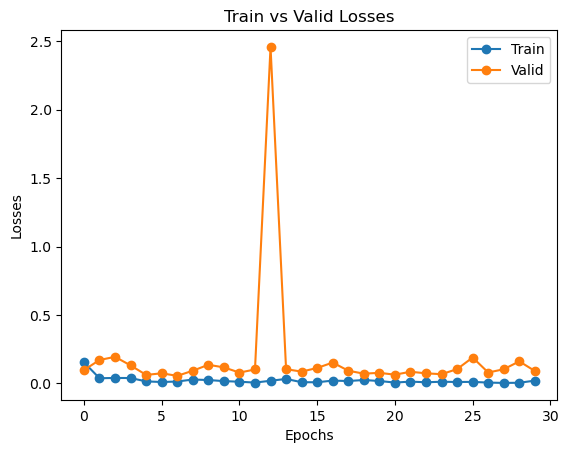

In [12]:
plt.plot(ep,train_losses,'o-')
plt.plot(ep,valid_losses,'o-')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

In [9]:
model.load_state_dict(torch.load('model_ERA_Small_lr0015.pt'))

<All keys matched successfully>

In [14]:
test_loss = 0.0
class_correct = list(0. for i in range(14))
class_total = list(0. for i in range(14))
model.eval()
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    data=transforms.functional.invert(data)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)   
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(0,target.size()[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
                
for i in range(14):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 55.010990

Test Accuracy of     +:  0% ( 0/45)
Test Accuracy of     -:  0% ( 0/46)
Test Accuracy of     0:  0% ( 0/46)
Test Accuracy of     1:  0% ( 0/45)
Test Accuracy of     2:  0% ( 0/47)
Test Accuracy of     3:  0% ( 0/47)
Test Accuracy of     4:  8% ( 4/47)
Test Accuracy of     5:  0% ( 0/49)
Test Accuracy of     6:  0% ( 0/49)
Test Accuracy of     7:  0% ( 0/48)
Test Accuracy of     8:  0% ( 0/48)
Test Accuracy of     9:  0% ( 0/50)
Test Accuracy of   div:  0% ( 0/39)
Test Accuracy of times: 100% (43/43)

Test Accuracy (Overall):  7% (47/649)
